### Carregar bibliotecas e dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap as sh
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


b:\Pós\hospital-ai-diagnosis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carregar dataset e dividir dados de treino e teste

Este dataset já passou pelo pré-processamento:
- Valores ausentes imputados
- Escalonamento das features
- Salvo em CSV para garantir reprodutibilidade

#### Carregamento do csv

In [2]:
dataset = pd.read_csv("B:/Pós/hospital-ai-diagnosis/dados/processados/processado_diabetes.csv")






#### Separar target e features

In [7]:
X = dataset.drop("Outcome", axis=1)
y = dataset["Outcome"]

#### Separar treino e teste

Dividimos os dados em treino e teste mantendo a proporção das classes (stratify=y).  
Isso garante que o desequilíbrio original seja preservado no teste.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Verificar o balanceamento do conjunto de treino antes do SMOTE

In [9]:
y_train.value_counts()

Outcome
0    400
1    214
Name: count, dtype: int64

### Balancear classes para treino

SMOTE foi utilizado para balancear as classes do conjunto de treino.  
Ele cria amostras sintéticas da classe minoritária (diabéticos), equilibrando o dataset e aumentando a sensibilidade (recall) do modelo

In [10]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

### Treinar Modelos

Usamos três modelos para comparação:
- Logistic Regression: simples e interpretável
- Decision Tree: visual e interpretável, mas mais instável
- Random Forest: ensemble de árvores, geralmente mais robusto  
  
Todos com class_weight='balanced' para compensar ligeiro desbalanceamento

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.82      0.75      0.79       100
           1       0.60      0.70      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



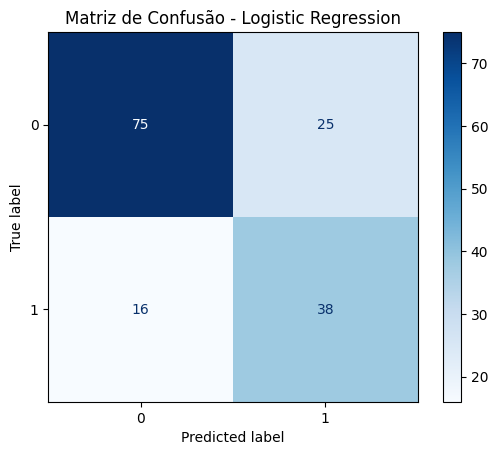

--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       100
           1       0.60      0.57      0.58        54

    accuracy                           0.71       154
   macro avg       0.69      0.68      0.68       154
weighted avg       0.71      0.71      0.71       154



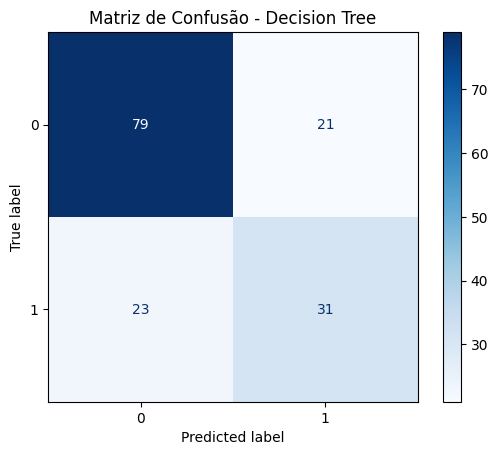

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       100
           1       0.63      0.54      0.58        54

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.69       154
weighted avg       0.72      0.73      0.72       154



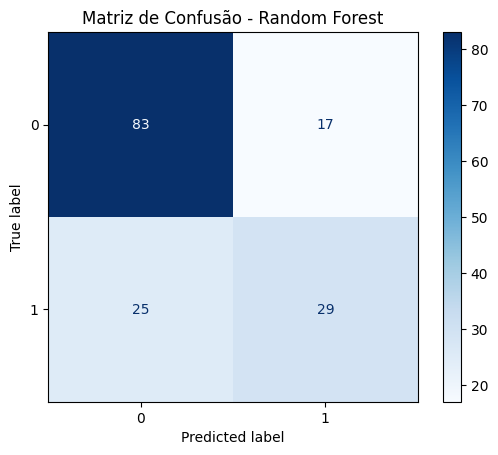

In [11]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42)
}

# Treino e avaliação
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))
    
    # Plot da matriz de confusão
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test,
        display_labels=[0, 1],
        cmap=plt.cm.Blues,
        normalize=None
    )
    disp.ax_.set_title(f"Matriz de Confusão - {name}")
    plt.show()

### Feature importance (Logistic Regression, Decision Tree e Random Forest)

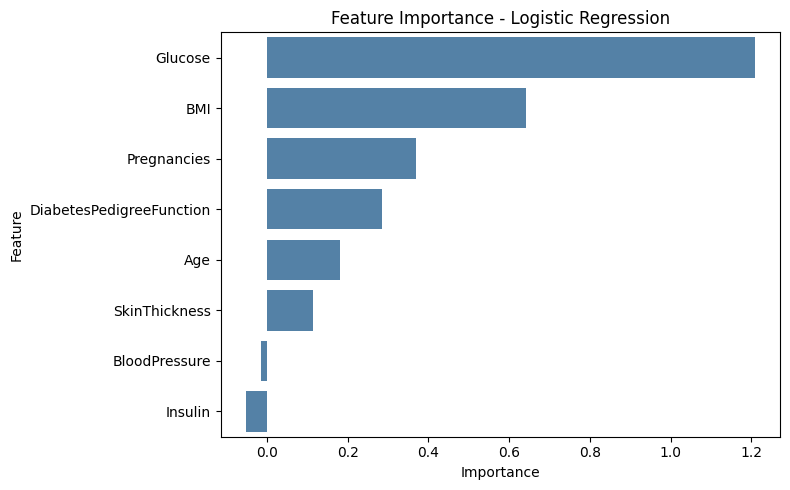

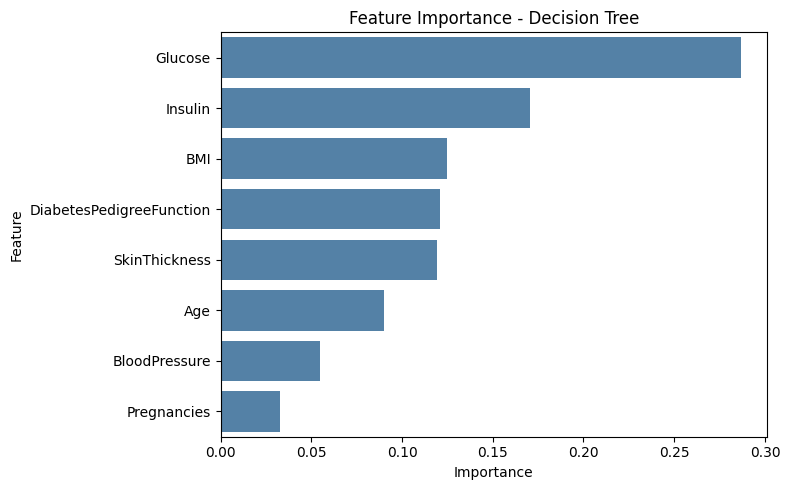

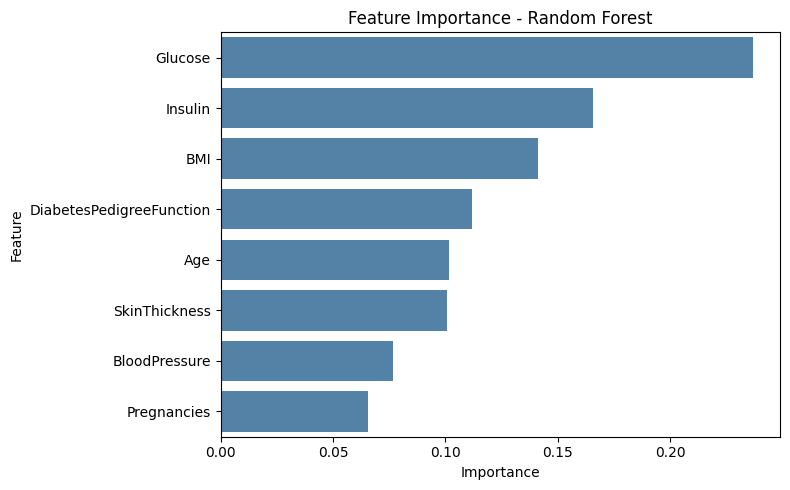

In [ ]:

for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = model.coef_[0]
    else:
        continue

    # Cria dataframe com os valores de importância
    feat_imp = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(10)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=feat_imp, x='Importance', y='Feature', color='steelblue')
    plt.title(f'Feature Importance - {name}')
    plt.tight_layout()
    plt.show()

### SHAP (interpretação local e global)

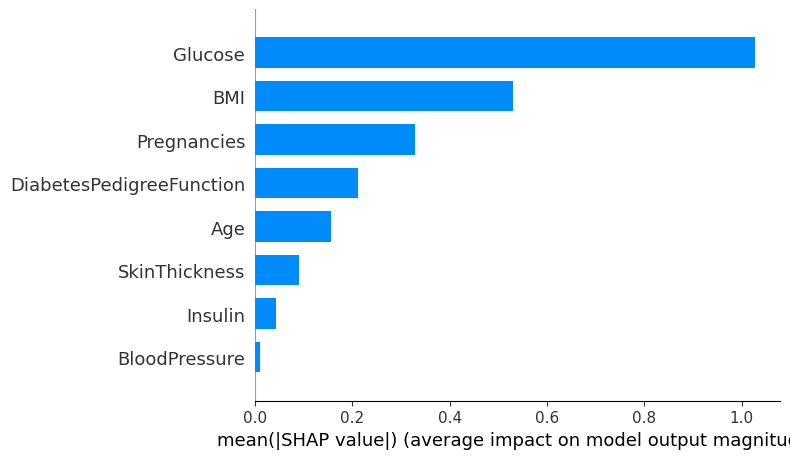

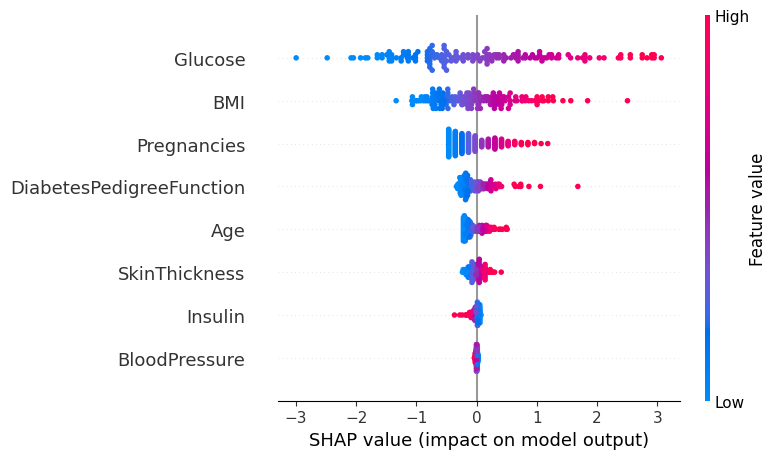

In [ ]:
final_model = models['Logistic Regression']

explainer = sh.Explainer(final_model, X_train)
sh_values = explainer(X_test)

# Gráfico de importância média das features
sh.summary_plot(sh_values, X_test, plot_type="bar")

# Gráfico de dispersão (mostra o impacto de cada feature)
sh.summary_plot(sh_values, X_test)

## 🧩 Conclusão do Pipeline de Modelagem

- **Logistic Regression** foi escolhida como modelo final devido ao maior *recall* (0.70) para a classe de pacientes diabéticos, garantindo melhor detecção de casos positivos — o que é fundamental em contextos médicos, onde falsos negativos podem representar risco à saúde do paciente.  

- **Decision Tree** apresentou *recall* inferior (0.57), indicando perda significativa de casos da classe minoritária.  

- **Random Forest** obteve leve vantagem em *precision* (0.63), mas *recall* insuficiente (0.54), tornando-o menos adequado para o objetivo de maximizar a sensibilidade diagnóstica.  

---

### 🔍 Interpretação das variáveis

A análise de **Feature Importance** indicou que as variáveis mais relevantes para o modelo são:

| Rank | Variável                  | Importância |
|------|---------------------------|--------------|
| 1️⃣ | Glucose                   | 1.208 |
| 2️⃣ | BMI                       | 0.642 |
| 3️⃣ | Pregnancies               | 0.369 |
| 4️⃣ | DiabetesPedigreeFunction  | 0.285 |
| 5️⃣ | Age                       | 0.182 |

A análise de **valores SHAP** confirmou essa tendência, com as variáveis `Glucose`, `BMI` e `Pregnancies` apresentando maior influência sobre o diagnóstico positivo.  
Os valores de SHAP mostraram que níveis elevados de glicose e índice de massa corporal aumentam significativamente a probabilidade de o paciente ser classificado como diabético.  
Além disso, um número maior de gestações também contribui para o risco previsto, o que está alinhado com evidências clínicas conhecidas.

---

### 🧠 Discussão crítica

O modelo demonstra bom equilíbrio entre desempenho estatístico e interpretação clínica, características essenciais para aplicações médicas.  
Ainda assim, o uso prático desse tipo de modelo deve ser **apenas de apoio ao diagnóstico médico**, servindo como ferramenta complementar para triagem ou priorização de pacientes.  
A decisão final deve sempre permanecer sob responsabilidade do profissional de saúde, garantindo segurança e contexto clínico adequado.

---

### ✅ Conclusão geral

Em problemas de saúde, prioriza-se **sensibilidade (recall)** sobre precisão, com o objetivo de reduzir falsos negativos.  
Assim, a **Regressão Logística** se mostrou o modelo mais adequado neste pipeline, equilibrando performance, interpretabilidade e aderência ao contexto clínico.